In [1]:
from math import log, sqrt, exp
from statistics import NormalDist

class BlackScholes:
    @staticmethod
    def black_scholes_call(spot, strike, time_to_expiry, volatility):
        d1 = (log(spot) - log(strike) + (0.5 * volatility * volatility) * time_to_expiry) / (volatility * sqrt(time_to_expiry))
        d2 = d1 - volatility * sqrt(time_to_expiry)
        call_price = spot * NormalDist().cdf(d1) - strike * NormalDist().cdf(d2)
        return call_price

    @staticmethod
    def black_scholes_put(spot, strike, time_to_expiry, volatility):
        d1 = (log(spot / strike) + (0.5 * volatility * volatility) * time_to_expiry) / (volatility * sqrt(time_to_expiry))
        d2 = d1 - volatility * sqrt(time_to_expiry)
        put_price = strike * NormalDist().cdf(-d2) - spot * NormalDist().cdf(-d1)
        return put_price

    @staticmethod
    def delta(spot, strike, time_to_expiry, volatility):
        d1 = (log(spot) - log(strike) + (0.5 * volatility * volatility) * time_to_expiry) / (volatility * sqrt(time_to_expiry))
        return NormalDist().cdf(d1)

    @staticmethod
    def gamma(spot, strike, time_to_expiry, volatility):
        d1 = (log(spot) - log(strike) + (0.5 * volatility * volatility) * time_to_expiry) / (volatility * sqrt(time_to_expiry))
        return NormalDist().pdf(d1) / (spot * volatility * sqrt(time_to_expiry))

    @staticmethod
    def vega(spot, strike, time_to_expiry, volatility):
        d1 = (log(spot) - log(strike) + (0.5 * volatility * volatility) * time_to_expiry) / (volatility * sqrt(time_to_expiry))
        return NormalDist().pdf(d1) * (spot * sqrt(time_to_expiry)) / 100

    @staticmethod
    def implied_volatility(call_price, spot, strike, time_to_expiry, max_iterations=200, tolerance=1e-10):
        low_vol = 0.01
        high_vol = 1.0
        volatility = (low_vol + high_vol) / 2.0  # Initial guess as the midpoint
        # binary search ts
        for _ in range(max_iterations):
            estimated_price = BlackScholes.black_scholes_call(spot, strike, time_to_expiry, volatility)
            diff = estimated_price - call_price
            if abs(diff) < tolerance:
                break
            elif diff > 0:
                high_vol = volatility
            else:
                low_vol = volatility
            volatility = (low_vol + high_vol) / 2.0
        return volatility

In [12]:
import pandas as pd

# read data into dataframe
df = pd.concat([
    pd.read_csv(f'data/prices_round_3_day_0.csv', sep=';'),
    pd.read_csv(f'data/prices_round_3_day_1.csv', sep=';'),
    pd.read_csv(f'data/prices_round_3_day_2.csv', sep=';')
], ignore_index=True)

df['timestamp'] += df['day'] * 1_000_000

# drop unnecessary columns
df.drop(columns=[
    'day', 'bid_price_1', 'bid_volume_1', 'bid_price_2',
    'bid_volume_2', 'bid_price_3', 'bid_volume_3', 'ask_price_1',
    'ask_volume_1', 'ask_price_2', 'ask_volume_2', 'ask_price_3',
    'ask_volume_3', 'profit_and_loss'
], inplace=True)

spot_prices = df[df['product'] == 'VOLCANIC_ROCK'][['timestamp', 'mid_price']].rename(columns={'mid_price': 'spot_price'})

voucher_dfs = {
    9500: pd.merge(df[df['product'] == 'VOLCANIC_ROCK_VOUCHER_9500'], spot_prices, on='timestamp', how='left'),
    9750: pd.merge(df[df['product'] == 'VOLCANIC_ROCK_VOUCHER_9750'], spot_prices, on='timestamp', how='left'),
    10000: pd.merge(df[df['product'] == 'VOLCANIC_ROCK_VOUCHER_10000'], spot_prices, on='timestamp', how='left'),
    10250: pd.merge(df[df['product'] == 'VOLCANIC_ROCK_VOUCHER_10250'], spot_prices, on='timestamp', how='left'),
    10500: pd.merge(df[df['product'] == 'VOLCANIC_ROCK_VOUCHER_10500'], spot_prices, on='timestamp', how='left')
}

# calculate implied and realized volality for each option
rv_window = 30  # rolling window size for realized volatility
for strike, voucher_df in voucher_dfs.items():
    voucher_df['time_to_expiry'] = (5/7) - (voucher_df['timestamp'] / 1000000) / 7 # round 3: expires in 7 - 2 days
    voucher_df['realized_volatility'] = voucher_df['mid_price'].rolling(window=rv_window).std()*sqrt(1/rv_window)
    voucher_df['implied_volatility'] = voucher_df.apply(
        lambda row: BlackScholes.implied_volatility(row['mid_price'], row['spot_price'], strike, row['time_to_expiry']), axis=1
    )
    
    # calculate spread between IV and RV
    voucher_df['spread'] = voucher_df['implied_volatility'] - voucher_df['realized_volatility']
    
    voucher_dfs[strike] = voucher_df[['timestamp', 'spot_price', 'mid_price', 'realized_volatility', 'implied_volatility', 'spread']]

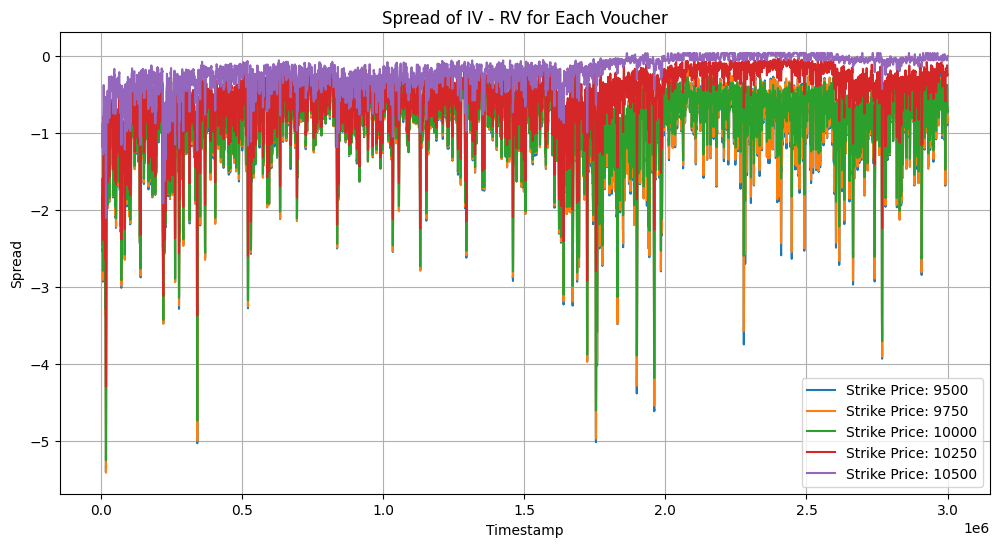

In [17]:
# plot the spread against time
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for strike, voucher_df in voucher_dfs.items():
    plt.plot(voucher_df['timestamp'], voucher_df['spread'], label=f'Strike Price: {strike}')
plt.title(f'Spread of IV - RV for Each Voucher')
plt.xlabel('Timestamp')
plt.ylabel('Spread')
plt.legend()
plt.grid()
plt.savefig('iv_rv_spread.png')
plt.show()

In [16]:
for strike, voucher_df in voucher_dfs.items():
    positive_spreads = (voucher_df['spread'] > 0).sum()
    zero_spreads = (voucher_df['spread'] == 0).sum()
    negative_spreads = (voucher_df['spread'] < 0).sum()
    total_spreads = len(voucher_df)
    percentage_positive = (positive_spreads / total_spreads) * 100
    percentage_negative = (negative_spreads / total_spreads) * 100
    percentage_zero = (zero_spreads / total_spreads) * 100
    print(f'Strike Price: {strike}, %spreads > 0: {percentage_positive}%, %spreads < 0: {percentage_negative}%, %spreads = 0: {percentage_zero}%')
    print(f'Average spread: {voucher_df["spread"].mean()}')


Strike Price: 9500, %spreads > 0: 0.0%, %spreads < 0: 99.90333333333334%, %spreads = 0: 0.0%
Average spread: -0.9060774841477346
Strike Price: 9750, %spreads > 0: 0.0%, %spreads < 0: 99.90333333333334%, %spreads = 0: 0.0%
Average spread: -0.8989879346093873
Strike Price: 10000, %spreads > 0: 0.0%, %spreads < 0: 99.90333333333334%, %spreads = 0: 0.0%
Average spread: -0.8591902922496877
Strike Price: 10250, %spreads > 0: 0.0%, %spreads < 0: 99.90333333333334%, %spreads = 0: 0.0%
Average spread: -0.5535234938570519
Strike Price: 10500, %spreads > 0: 10.966666666666667%, %spreads < 0: 88.93666666666667%, %spreads = 0: 0.0%
Average spread: -0.21217904353952263
